#ConTextTransformer

This is a demo notebook for a simple multi-modal Transformer model that has been pre-trained on the ConText dataset.

The [Con-Text dataset](https://staff.fnwi.uva.nl/s.karaoglu/datasetWeb/Dataset.html) is built from two sub-categories of the ImageNet dataset: "building" and "place of business". The task is fine-grained classification. The dataset consists of 28 categories (e.g. "Bakery", "Bistro", "Restaurant", "Cafe", "Pizzeria", etc.) with 24,255 images in total.

Using scene text (when available) provides high-level semantic information that is useful for the task. However, not all the images have text in them. Moreover, high variability of text size, location, resolution and style and, uncontrolled environmental settings ( illumination ) make text recognition from this dataset harder.

In this ConTextTransformer demo we first use three pre-trained models for feature extraction: a ResNet50, an OCR, and the FastText word embedding. Then we project the visual (ResNet) and textual (FastText) features to a common dimensionality (Linear Projections) and we feed them into the Tansformer Encoder. Finally, the MLP head takes the output feature of the CLS token and predicts one of the classes with Softmax.

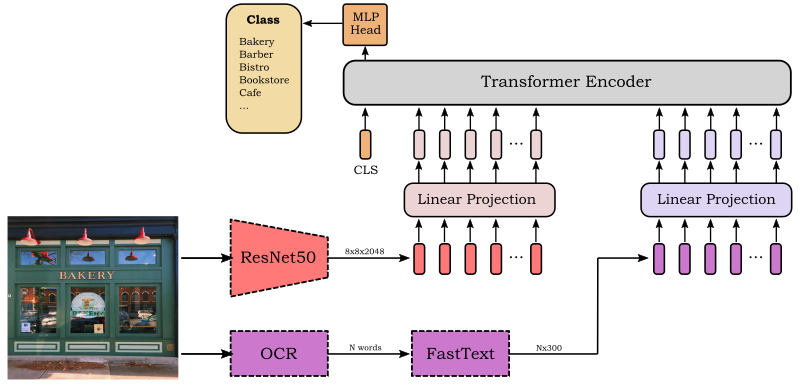

Let's start by installing and importing the necessary Python modules.

In [51]:
!pip install einops
!pip install fasttext-wheel
!pip install fasttext

# for the OCR module (see below)
!pip install opencv-python-headless==4.1.2.30
!pip install easyocr

  Using cached fasttext-0.9.2.tar.gz (68 kB)
  ERROR: Command errored out with exit status 1:
   command: /anaconda/envs/azureml_py38_PT_and_TF/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ycjryq8s/fasttext/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ycjryq8s/fasttext/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-79vdkp60
       cwd: /tmp/pip-install-ycjryq8s/fasttext/
  Complete output (79 lines):
  /anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/setuptools/dist.py:476: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'descr

In [52]:
from PIL import Image
import numpy as np
import easyocr

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
1.12.0


We must download the pre-trained FastText model and load it into memory. Unfortunately this takes around 20 minutes in Colab. 

In [53]:
fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('cc.en.300.bin')

## Define and create the model

Here we define the architecture of our model. See the comments in the code for better understanding. 

For the Transformer Encoder we use the built-in [PyTorch Transformer Layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

In [54]:
# class ConTextTransformer(nn.Module):
#     def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
#         super().__init__()

#         # Visual feature extractor
#         resnet50 = torchvision.models.resnet50(pretrained=True)
#         modules=list(resnet50.children())[:-2]
#         self.resnet50=nn.Sequential(*modules)
#         for param in self.resnet50.parameters():
#             param.requires_grad = False
#         self.num_cnn_features = 64  # 8x8
#         self.dim_cnn_features = 2048
#         self.dim_fasttext_features = 300

#         # Embeddings for the visual and textual features
#         self.cnn_feature_to_embedding = nn.Linear(self.dim_cnn_features, dim)
#         self.fasttext_feature_to_embedding = nn.Linear(self.dim_fasttext_features, dim)

#         # Learnable position embeddings (for the visual features) and CLS token
#         self.pos_embedding = nn.Parameter(torch.randn(1, self.num_cnn_features + 1, dim))
#         self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

#         # The Transformer Encoder
#         encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
#         encoder_norm = nn.LayerNorm(dim)
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

#         # Classification Head (MLP)
#         self.to_cls_token = nn.Identity()
#         self.mlp_head = nn.Sequential(
#             nn.Linear(dim, mlp_dim),
#             nn.GELU(),
#             nn.Linear(mlp_dim, num_classes)
#         )

#     def forward(self, img, txt, mask=None):
#         x = self.resnet50(img)
#         x = rearrange(x, 'b d h w -> b (h w) d') # this makes a sequence of 64 videual features
#         x = self.cnn_feature_to_embedding(x)

#         cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
#         x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding

#         x2 = self.fasttext_feature_to_embedding(txt.float())
#         x = torch.cat((x,x2), dim=1)
#         x = self.transformer(x)

#         x = self.to_cls_token(x[:, 0])
#         return self.mlp_head(x)

In [55]:
import time, os, json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

from einops import rearrange

import fasttext
import fasttext.util

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

class ConTextTransformer(nn.Module):
    def __init__(self, *, image_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()

        # Visual feature extractor using EfficientNet
        efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
        modules = list(efficientnet.children())[:-2]
        self.efficientnet = nn.Sequential(*modules)
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        self.num_cnn_features = 49  # 7x7
        self.dim_cnn_features = 1280
        self.dim_fasttext_features = 300

        # Embeddings for the visual and textual features
        self.cnn_feature_to_embedding = nn.Linear(self.dim_cnn_features, dim)
        self.fasttext_feature_to_embedding = nn.Linear(self.dim_fasttext_features, dim)

        # Learnable position embeddings (for the visual features) and CLS token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_cnn_features + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # The Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, batch_first=True)
        encoder_norm = nn.LayerNorm(dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Classification Head (MLP)
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, txt, mask=None):
        x = self.efficientnet(img)
        x = rearrange(x, 'b d h w -> b (h w) d') # this makes a sequence of 49 visual features
        x = self.cnn_feature_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding

        x2 = self.fasttext_feature_to_embedding(txt.float())
        x = torch.cat((x, x2), dim=1)
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

cuda
1.12.0


Now we can create our model and load the pre-trained weights. 

The particular model instance we use in this demo has only **two encoder layers with 4 heads**, the dimensions of embeddings and encoder linear layers are 256 and 512 respectively.

In [56]:
model = ConTextTransformer(image_size=256, num_classes=28, channels=3, dim=256, depth=2, heads=4, mlp_dim=512)

#!wget https://raw.githubusercontent.com/lluisgomez/ConTextTransformer/main/all_best.pth

model.load_state_dict(torch.load('all_best.pth'))
model.to(device)
model.eval()

/anaconda/envs/azureml_py38_PT_and_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/xnmaster/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
19.5%

100.0%


RuntimeError: Error(s) in loading state_dict for ConTextTransformer:
	Missing key(s) in state_dict: "efficientnet.0.0.0.weight", "efficientnet.0.0.1.weight", "efficientnet.0.0.1.bias", "efficientnet.0.0.1.running_mean", "efficientnet.0.0.1.running_var", "efficientnet.0.1.0.block.0.0.weight", "efficientnet.0.1.0.block.0.1.weight", "efficientnet.0.1.0.block.0.1.bias", "efficientnet.0.1.0.block.0.1.running_mean", "efficientnet.0.1.0.block.0.1.running_var", "efficientnet.0.1.0.block.1.fc1.weight", "efficientnet.0.1.0.block.1.fc1.bias", "efficientnet.0.1.0.block.1.fc2.weight", "efficientnet.0.1.0.block.1.fc2.bias", "efficientnet.0.1.0.block.2.0.weight", "efficientnet.0.1.0.block.2.1.weight", "efficientnet.0.1.0.block.2.1.bias", "efficientnet.0.1.0.block.2.1.running_mean", "efficientnet.0.1.0.block.2.1.running_var", "efficientnet.0.2.0.block.0.0.weight", "efficientnet.0.2.0.block.0.1.weight", "efficientnet.0.2.0.block.0.1.bias", "efficientnet.0.2.0.block.0.1.running_mean", "efficientnet.0.2.0.block.0.1.running_var", "efficientnet.0.2.0.block.1.0.weight", "efficientnet.0.2.0.block.1.1.weight", "efficientnet.0.2.0.block.1.1.bias", "efficientnet.0.2.0.block.1.1.running_mean", "efficientnet.0.2.0.block.1.1.running_var", "efficientnet.0.2.0.block.2.fc1.weight", "efficientnet.0.2.0.block.2.fc1.bias", "efficientnet.0.2.0.block.2.fc2.weight", "efficientnet.0.2.0.block.2.fc2.bias", "efficientnet.0.2.0.block.3.0.weight", "efficientnet.0.2.0.block.3.1.weight", "efficientnet.0.2.0.block.3.1.bias", "efficientnet.0.2.0.block.3.1.running_mean", "efficientnet.0.2.0.block.3.1.running_var", "efficientnet.0.2.1.block.0.0.weight", "efficientnet.0.2.1.block.0.1.weight", "efficientnet.0.2.1.block.0.1.bias", "efficientnet.0.2.1.block.0.1.running_mean", "efficientnet.0.2.1.block.0.1.running_var", "efficientnet.0.2.1.block.1.0.weight", "efficientnet.0.2.1.block.1.1.weight", "efficientnet.0.2.1.block.1.1.bias", "efficientnet.0.2.1.block.1.1.running_mean", "efficientnet.0.2.1.block.1.1.running_var", "efficientnet.0.2.1.block.2.fc1.weight", "efficientnet.0.2.1.block.2.fc1.bias", "efficientnet.0.2.1.block.2.fc2.weight", "efficientnet.0.2.1.block.2.fc2.bias", "efficientnet.0.2.1.block.3.0.weight", "efficientnet.0.2.1.block.3.1.weight", "efficientnet.0.2.1.block.3.1.bias", "efficientnet.0.2.1.block.3.1.running_mean", "efficientnet.0.2.1.block.3.1.running_var", "efficientnet.0.3.0.block.0.0.weight", "efficientnet.0.3.0.block.0.1.weight", "efficientnet.0.3.0.block.0.1.bias", "efficientnet.0.3.0.block.0.1.running_mean", "efficientnet.0.3.0.block.0.1.running_var", "efficientnet.0.3.0.block.1.0.weight", "efficientnet.0.3.0.block.1.1.weight", "efficientnet.0.3.0.block.1.1.bias", "efficientnet.0.3.0.block.1.1.running_mean", "efficientnet.0.3.0.block.1.1.running_var", "efficientnet.0.3.0.block.2.fc1.weight", "efficientnet.0.3.0.block.2.fc1.bias", "efficientnet.0.3.0.block.2.fc2.weight", "efficientnet.0.3.0.block.2.fc2.bias", "efficientnet.0.3.0.block.3.0.weight", "efficientnet.0.3.0.block.3.1.weight", "efficientnet.0.3.0.block.3.1.bias", "efficientnet.0.3.0.block.3.1.running_mean", "efficientnet.0.3.0.block.3.1.running_var", "efficientnet.0.3.1.block.0.0.weight", "efficientnet.0.3.1.block.0.1.weight", "efficientnet.0.3.1.block.0.1.bias", "efficientnet.0.3.1.block.0.1.running_mean", "efficientnet.0.3.1.block.0.1.running_var", "efficientnet.0.3.1.block.1.0.weight", "efficientnet.0.3.1.block.1.1.weight", "efficientnet.0.3.1.block.1.1.bias", "efficientnet.0.3.1.block.1.1.running_mean", "efficientnet.0.3.1.block.1.1.running_var", "efficientnet.0.3.1.block.2.fc1.weight", "efficientnet.0.3.1.block.2.fc1.bias", "efficientnet.0.3.1.block.2.fc2.weight", "efficientnet.0.3.1.block.2.fc2.bias", "efficientnet.0.3.1.block.3.0.weight", "efficientnet.0.3.1.block.3.1.weight", "efficientnet.0.3.1.block.3.1.bias", "efficientnet.0.3.1.block.3.1.running_mean", "efficientnet.0.3.1.block.3.1.running_var", "efficientnet.0.4.0.block.0.0.weight", "efficientnet.0.4.0.block.0.1.weight", "efficientnet.0.4.0.block.0.1.bias", "efficientnet.0.4.0.block.0.1.running_mean", "efficientnet.0.4.0.block.0.1.running_var", "efficientnet.0.4.0.block.1.0.weight", "efficientnet.0.4.0.block.1.1.weight", "efficientnet.0.4.0.block.1.1.bias", "efficientnet.0.4.0.block.1.1.running_mean", "efficientnet.0.4.0.block.1.1.running_var", "efficientnet.0.4.0.block.2.fc1.weight", "efficientnet.0.4.0.block.2.fc1.bias", "efficientnet.0.4.0.block.2.fc2.weight", "efficientnet.0.4.0.block.2.fc2.bias", "efficientnet.0.4.0.block.3.0.weight", "efficientnet.0.4.0.block.3.1.weight", "efficientnet.0.4.0.block.3.1.bias", "efficientnet.0.4.0.block.3.1.running_mean", "efficientnet.0.4.0.block.3.1.running_var", "efficientnet.0.4.1.block.0.0.weight", "efficientnet.0.4.1.block.0.1.weight", "efficientnet.0.4.1.block.0.1.bias", "efficientnet.0.4.1.block.0.1.running_mean", "efficientnet.0.4.1.block.0.1.running_var", "efficientnet.0.4.1.block.1.0.weight", "efficientnet.0.4.1.block.1.1.weight", "efficientnet.0.4.1.block.1.1.bias", "efficientnet.0.4.1.block.1.1.running_mean", "efficientnet.0.4.1.block.1.1.running_var", "efficientnet.0.4.1.block.2.fc1.weight", "efficientnet.0.4.1.block.2.fc1.bias", "efficientnet.0.4.1.block.2.fc2.weight", "efficientnet.0.4.1.block.2.fc2.bias", "efficientnet.0.4.1.block.3.0.weight", "efficientnet.0.4.1.block.3.1.weight", "efficientnet.0.4.1.block.3.1.bias", "efficientnet.0.4.1.block.3.1.running_mean", "efficientnet.0.4.1.block.3.1.running_var", "efficientnet.0.4.2.block.0.0.weight", "efficientnet.0.4.2.block.0.1.weight", "efficientnet.0.4.2.block.0.1.bias", "efficientnet.0.4.2.block.0.1.running_mean", "efficientnet.0.4.2.block.0.1.running_var", "efficientnet.0.4.2.block.1.0.weight", "efficientnet.0.4.2.block.1.1.weight", "efficientnet.0.4.2.block.1.1.bias", "efficientnet.0.4.2.block.1.1.running_mean", "efficientnet.0.4.2.block.1.1.running_var", "efficientnet.0.4.2.block.2.fc1.weight", "efficientnet.0.4.2.block.2.fc1.bias", "efficientnet.0.4.2.block.2.fc2.weight", "efficientnet.0.4.2.block.2.fc2.bias", "efficientnet.0.4.2.block.3.0.weight", "efficientnet.0.4.2.block.3.1.weight", "efficientnet.0.4.2.block.3.1.bias", "efficientnet.0.4.2.block.3.1.running_mean", "efficientnet.0.4.2.block.3.1.running_var", "efficientnet.0.5.0.block.0.0.weight", "efficientnet.0.5.0.block.0.1.weight", "efficientnet.0.5.0.block.0.1.bias", "efficientnet.0.5.0.block.0.1.running_mean", "efficientnet.0.5.0.block.0.1.running_var", "efficientnet.0.5.0.block.1.0.weight", "efficientnet.0.5.0.block.1.1.weight", "efficientnet.0.5.0.block.1.1.bias", "efficientnet.0.5.0.block.1.1.running_mean", "efficientnet.0.5.0.block.1.1.running_var", "efficientnet.0.5.0.block.2.fc1.weight", "efficientnet.0.5.0.block.2.fc1.bias", "efficientnet.0.5.0.block.2.fc2.weight", "efficientnet.0.5.0.block.2.fc2.bias", "efficientnet.0.5.0.block.3.0.weight", "efficientnet.0.5.0.block.3.1.weight", "efficientnet.0.5.0.block.3.1.bias", "efficientnet.0.5.0.block.3.1.running_mean", "efficientnet.0.5.0.block.3.1.running_var", "efficientnet.0.5.1.block.0.0.weight", "efficientnet.0.5.1.block.0.1.weight", "efficientnet.0.5.1.block.0.1.bias", "efficientnet.0.5.1.block.0.1.running_mean", "efficientnet.0.5.1.block.0.1.running_var", "efficientnet.0.5.1.block.1.0.weight", "efficientnet.0.5.1.block.1.1.weight", "efficientnet.0.5.1.block.1.1.bias", "efficientnet.0.5.1.block.1.1.running_mean", "efficientnet.0.5.1.block.1.1.running_var", "efficientnet.0.5.1.block.2.fc1.weight", "efficientnet.0.5.1.block.2.fc1.bias", "efficientnet.0.5.1.block.2.fc2.weight", "efficientnet.0.5.1.block.2.fc2.bias", "efficientnet.0.5.1.block.3.0.weight", "efficientnet.0.5.1.block.3.1.weight", "efficientnet.0.5.1.block.3.1.bias", "efficientnet.0.5.1.block.3.1.running_mean", "efficientnet.0.5.1.block.3.1.running_var", "efficientnet.0.5.2.block.0.0.weight", "efficientnet.0.5.2.block.0.1.weight", "efficientnet.0.5.2.block.0.1.bias", "efficientnet.0.5.2.block.0.1.running_mean", "efficientnet.0.5.2.block.0.1.running_var", "efficientnet.0.5.2.block.1.0.weight", "efficientnet.0.5.2.block.1.1.weight", "efficientnet.0.5.2.block.1.1.bias", "efficientnet.0.5.2.block.1.1.running_mean", "efficientnet.0.5.2.block.1.1.running_var", "efficientnet.0.5.2.block.2.fc1.weight", "efficientnet.0.5.2.block.2.fc1.bias", "efficientnet.0.5.2.block.2.fc2.weight", "efficientnet.0.5.2.block.2.fc2.bias", "efficientnet.0.5.2.block.3.0.weight", "efficientnet.0.5.2.block.3.1.weight", "efficientnet.0.5.2.block.3.1.bias", "efficientnet.0.5.2.block.3.1.running_mean", "efficientnet.0.5.2.block.3.1.running_var", "efficientnet.0.6.0.block.0.0.weight", "efficientnet.0.6.0.block.0.1.weight", "efficientnet.0.6.0.block.0.1.bias", "efficientnet.0.6.0.block.0.1.running_mean", "efficientnet.0.6.0.block.0.1.running_var", "efficientnet.0.6.0.block.1.0.weight", "efficientnet.0.6.0.block.1.1.weight", "efficientnet.0.6.0.block.1.1.bias", "efficientnet.0.6.0.block.1.1.running_mean", "efficientnet.0.6.0.block.1.1.running_var", "efficientnet.0.6.0.block.2.fc1.weight", "efficientnet.0.6.0.block.2.fc1.bias", "efficientnet.0.6.0.block.2.fc2.weight", "efficientnet.0.6.0.block.2.fc2.bias", "efficientnet.0.6.0.block.3.0.weight", "efficientnet.0.6.0.block.3.1.weight", "efficientnet.0.6.0.block.3.1.bias", "efficientnet.0.6.0.block.3.1.running_mean", "efficientnet.0.6.0.block.3.1.running_var", "efficientnet.0.6.1.block.0.0.weight", "efficientnet.0.6.1.block.0.1.weight", "efficientnet.0.6.1.block.0.1.bias", "efficientnet.0.6.1.block.0.1.running_mean", "efficientnet.0.6.1.block.0.1.running_var", "efficientnet.0.6.1.block.1.0.weight", "efficientnet.0.6.1.block.1.1.weight", "efficientnet.0.6.1.block.1.1.bias", "efficientnet.0.6.1.block.1.1.running_mean", "efficientnet.0.6.1.block.1.1.running_var", "efficientnet.0.6.1.block.2.fc1.weight", "efficientnet.0.6.1.block.2.fc1.bias", "efficientnet.0.6.1.block.2.fc2.weight", "efficientnet.0.6.1.block.2.fc2.bias", "efficientnet.0.6.1.block.3.0.weight", "efficientnet.0.6.1.block.3.1.weight", "efficientnet.0.6.1.block.3.1.bias", "efficientnet.0.6.1.block.3.1.running_mean", "efficientnet.0.6.1.block.3.1.running_var", "efficientnet.0.6.2.block.0.0.weight", "efficientnet.0.6.2.block.0.1.weight", "efficientnet.0.6.2.block.0.1.bias", "efficientnet.0.6.2.block.0.1.running_mean", "efficientnet.0.6.2.block.0.1.running_var", "efficientnet.0.6.2.block.1.0.weight", "efficientnet.0.6.2.block.1.1.weight", "efficientnet.0.6.2.block.1.1.bias", "efficientnet.0.6.2.block.1.1.running_mean", "efficientnet.0.6.2.block.1.1.running_var", "efficientnet.0.6.2.block.2.fc1.weight", "efficientnet.0.6.2.block.2.fc1.bias", "efficientnet.0.6.2.block.2.fc2.weight", "efficientnet.0.6.2.block.2.fc2.bias", "efficientnet.0.6.2.block.3.0.weight", "efficientnet.0.6.2.block.3.1.weight", "efficientnet.0.6.2.block.3.1.bias", "efficientnet.0.6.2.block.3.1.running_mean", "efficientnet.0.6.2.block.3.1.running_var", "efficientnet.0.6.3.block.0.0.weight", "efficientnet.0.6.3.block.0.1.weight", "efficientnet.0.6.3.block.0.1.bias", "efficientnet.0.6.3.block.0.1.running_mean", "efficientnet.0.6.3.block.0.1.running_var", "efficientnet.0.6.3.block.1.0.weight", "efficientnet.0.6.3.block.1.1.weight", "efficientnet.0.6.3.block.1.1.bias", "efficientnet.0.6.3.block.1.1.running_mean", "efficientnet.0.6.3.block.1.1.running_var", "efficientnet.0.6.3.block.2.fc1.weight", "efficientnet.0.6.3.block.2.fc1.bias", "efficientnet.0.6.3.block.2.fc2.weight", "efficientnet.0.6.3.block.2.fc2.bias", "efficientnet.0.6.3.block.3.0.weight", "efficientnet.0.6.3.block.3.1.weight", "efficientnet.0.6.3.block.3.1.bias", "efficientnet.0.6.3.block.3.1.running_mean", "efficientnet.0.6.3.block.3.1.running_var", "efficientnet.0.7.0.block.0.0.weight", "efficientnet.0.7.0.block.0.1.weight", "efficientnet.0.7.0.block.0.1.bias", "efficientnet.0.7.0.block.0.1.running_mean", "efficientnet.0.7.0.block.0.1.running_var", "efficientnet.0.7.0.block.1.0.weight", "efficientnet.0.7.0.block.1.1.weight", "efficientnet.0.7.0.block.1.1.bias", "efficientnet.0.7.0.block.1.1.running_mean", "efficientnet.0.7.0.block.1.1.running_var", "efficientnet.0.7.0.block.2.fc1.weight", "efficientnet.0.7.0.block.2.fc1.bias", "efficientnet.0.7.0.block.2.fc2.weight", "efficientnet.0.7.0.block.2.fc2.bias", "efficientnet.0.7.0.block.3.0.weight", "efficientnet.0.7.0.block.3.1.weight", "efficientnet.0.7.0.block.3.1.bias", "efficientnet.0.7.0.block.3.1.running_mean", "efficientnet.0.7.0.block.3.1.running_var", "efficientnet.0.8.0.weight", "efficientnet.0.8.1.weight", "efficientnet.0.8.1.bias", "efficientnet.0.8.1.running_mean", "efficientnet.0.8.1.running_var". 
	Unexpected key(s) in state_dict: "resnet50.0.weight", "resnet50.1.weight", "resnet50.1.bias", "resnet50.1.running_mean", "resnet50.1.running_var", "resnet50.1.num_batches_tracked", "resnet50.4.0.conv1.weight", "resnet50.4.0.bn1.weight", "resnet50.4.0.bn1.bias", "resnet50.4.0.bn1.running_mean", "resnet50.4.0.bn1.running_var", "resnet50.4.0.bn1.num_batches_tracked", "resnet50.4.0.conv2.weight", "resnet50.4.0.bn2.weight", "resnet50.4.0.bn2.bias", "resnet50.4.0.bn2.running_mean", "resnet50.4.0.bn2.running_var", "resnet50.4.0.bn2.num_batches_tracked", "resnet50.4.0.conv3.weight", "resnet50.4.0.bn3.weight", "resnet50.4.0.bn3.bias", "resnet50.4.0.bn3.running_mean", "resnet50.4.0.bn3.running_var", "resnet50.4.0.bn3.num_batches_tracked", "resnet50.4.0.downsample.0.weight", "resnet50.4.0.downsample.1.weight", "resnet50.4.0.downsample.1.bias", "resnet50.4.0.downsample.1.running_mean", "resnet50.4.0.downsample.1.running_var", "resnet50.4.0.downsample.1.num_batches_tracked", "resnet50.4.1.conv1.weight", "resnet50.4.1.bn1.weight", "resnet50.4.1.bn1.bias", "resnet50.4.1.bn1.running_mean", "resnet50.4.1.bn1.running_var", "resnet50.4.1.bn1.num_batches_tracked", "resnet50.4.1.conv2.weight", "resnet50.4.1.bn2.weight", "resnet50.4.1.bn2.bias", "resnet50.4.1.bn2.running_mean", "resnet50.4.1.bn2.running_var", "resnet50.4.1.bn2.num_batches_tracked", "resnet50.4.1.conv3.weight", "resnet50.4.1.bn3.weight", "resnet50.4.1.bn3.bias", "resnet50.4.1.bn3.running_mean", "resnet50.4.1.bn3.running_var", "resnet50.4.1.bn3.num_batches_tracked", "resnet50.4.2.conv1.weight", "resnet50.4.2.bn1.weight", "resnet50.4.2.bn1.bias", "resnet50.4.2.bn1.running_mean", "resnet50.4.2.bn1.running_var", "resnet50.4.2.bn1.num_batches_tracked", "resnet50.4.2.conv2.weight", "resnet50.4.2.bn2.weight", "resnet50.4.2.bn2.bias", "resnet50.4.2.bn2.running_mean", "resnet50.4.2.bn2.running_var", "resnet50.4.2.bn2.num_batches_tracked", "resnet50.4.2.conv3.weight", "resnet50.4.2.bn3.weight", "resnet50.4.2.bn3.bias", "resnet50.4.2.bn3.running_mean", "resnet50.4.2.bn3.running_var", "resnet50.4.2.bn3.num_batches_tracked", "resnet50.5.0.conv1.weight", "resnet50.5.0.bn1.weight", "resnet50.5.0.bn1.bias", "resnet50.5.0.bn1.running_mean", "resnet50.5.0.bn1.running_var", "resnet50.5.0.bn1.num_batches_tracked", "resnet50.5.0.conv2.weight", "resnet50.5.0.bn2.weight", "resnet50.5.0.bn2.bias", "resnet50.5.0.bn2.running_mean", "resnet50.5.0.bn2.running_var", "resnet50.5.0.bn2.num_batches_tracked", "resnet50.5.0.conv3.weight", "resnet50.5.0.bn3.weight", "resnet50.5.0.bn3.bias", "resnet50.5.0.bn3.running_mean", "resnet50.5.0.bn3.running_var", "resnet50.5.0.bn3.num_batches_tracked", "resnet50.5.0.downsample.0.weight", "resnet50.5.0.downsample.1.weight", "resnet50.5.0.downsample.1.bias", "resnet50.5.0.downsample.1.running_mean", "resnet50.5.0.downsample.1.running_var", "resnet50.5.0.downsample.1.num_batches_tracked", "resnet50.5.1.conv1.weight", "resnet50.5.1.bn1.weight", "resnet50.5.1.bn1.bias", "resnet50.5.1.bn1.running_mean", "resnet50.5.1.bn1.running_var", "resnet50.5.1.bn1.num_batches_tracked", "resnet50.5.1.conv2.weight", "resnet50.5.1.bn2.weight", "resnet50.5.1.bn2.bias", "resnet50.5.1.bn2.running_mean", "resnet50.5.1.bn2.running_var", "resnet50.5.1.bn2.num_batches_tracked", "resnet50.5.1.conv3.weight", "resnet50.5.1.bn3.weight", "resnet50.5.1.bn3.bias", "resnet50.5.1.bn3.running_mean", "resnet50.5.1.bn3.running_var", "resnet50.5.1.bn3.num_batches_tracked", "resnet50.5.2.conv1.weight", "resnet50.5.2.bn1.weight", "resnet50.5.2.bn1.bias", "resnet50.5.2.bn1.running_mean", "resnet50.5.2.bn1.running_var", "resnet50.5.2.bn1.num_batches_tracked", "resnet50.5.2.conv2.weight", "resnet50.5.2.bn2.weight", "resnet50.5.2.bn2.bias", "resnet50.5.2.bn2.running_mean", "resnet50.5.2.bn2.running_var", "resnet50.5.2.bn2.num_batches_tracked", "resnet50.5.2.conv3.weight", "resnet50.5.2.bn3.weight", "resnet50.5.2.bn3.bias", "resnet50.5.2.bn3.running_mean", "resnet50.5.2.bn3.running_var", "resnet50.5.2.bn3.num_batches_tracked", "resnet50.5.3.conv1.weight", "resnet50.5.3.bn1.weight", "resnet50.5.3.bn1.bias", "resnet50.5.3.bn1.running_mean", "resnet50.5.3.bn1.running_var", "resnet50.5.3.bn1.num_batches_tracked", "resnet50.5.3.conv2.weight", "resnet50.5.3.bn2.weight", "resnet50.5.3.bn2.bias", "resnet50.5.3.bn2.running_mean", "resnet50.5.3.bn2.running_var", "resnet50.5.3.bn2.num_batches_tracked", "resnet50.5.3.conv3.weight", "resnet50.5.3.bn3.weight", "resnet50.5.3.bn3.bias", "resnet50.5.3.bn3.running_mean", "resnet50.5.3.bn3.running_var", "resnet50.5.3.bn3.num_batches_tracked", "resnet50.6.0.conv1.weight", "resnet50.6.0.bn1.weight", "resnet50.6.0.bn1.bias", "resnet50.6.0.bn1.running_mean", "resnet50.6.0.bn1.running_var", "resnet50.6.0.bn1.num_batches_tracked", "resnet50.6.0.conv2.weight", "resnet50.6.0.bn2.weight", "resnet50.6.0.bn2.bias", "resnet50.6.0.bn2.running_mean", "resnet50.6.0.bn2.running_var", "resnet50.6.0.bn2.num_batches_tracked", "resnet50.6.0.conv3.weight", "resnet50.6.0.bn3.weight", "resnet50.6.0.bn3.bias", "resnet50.6.0.bn3.running_mean", "resnet50.6.0.bn3.running_var", "resnet50.6.0.bn3.num_batches_tracked", "resnet50.6.0.downsample.0.weight", "resnet50.6.0.downsample.1.weight", "resnet50.6.0.downsample.1.bias", "resnet50.6.0.downsample.1.running_mean", "resnet50.6.0.downsample.1.running_var", "resnet50.6.0.downsample.1.num_batches_tracked", "resnet50.6.1.conv1.weight", "resnet50.6.1.bn1.weight", "resnet50.6.1.bn1.bias", "resnet50.6.1.bn1.running_mean", "resnet50.6.1.bn1.running_var", "resnet50.6.1.bn1.num_batches_tracked", "resnet50.6.1.conv2.weight", "resnet50.6.1.bn2.weight", "resnet50.6.1.bn2.bias", "resnet50.6.1.bn2.running_mean", "resnet50.6.1.bn2.running_var", "resnet50.6.1.bn2.num_batches_tracked", "resnet50.6.1.conv3.weight", "resnet50.6.1.bn3.weight", "resnet50.6.1.bn3.bias", "resnet50.6.1.bn3.running_mean", "resnet50.6.1.bn3.running_var", "resnet50.6.1.bn3.num_batches_tracked", "resnet50.6.2.conv1.weight", "resnet50.6.2.bn1.weight", "resnet50.6.2.bn1.bias", "resnet50.6.2.bn1.running_mean", "resnet50.6.2.bn1.running_var", "resnet50.6.2.bn1.num_batches_tracked", "resnet50.6.2.conv2.weight", "resnet50.6.2.bn2.weight", "resnet50.6.2.bn2.bias", "resnet50.6.2.bn2.running_mean", "resnet50.6.2.bn2.running_var", "resnet50.6.2.bn2.num_batches_tracked", "resnet50.6.2.conv3.weight", "resnet50.6.2.bn3.weight", "resnet50.6.2.bn3.bias", "resnet50.6.2.bn3.running_mean", "resnet50.6.2.bn3.running_var", "resnet50.6.2.bn3.num_batches_tracked", "resnet50.6.3.conv1.weight", "resnet50.6.3.bn1.weight", "resnet50.6.3.bn1.bias", "resnet50.6.3.bn1.running_mean", "resnet50.6.3.bn1.running_var", "resnet50.6.3.bn1.num_batches_tracked", "resnet50.6.3.conv2.weight", "resnet50.6.3.bn2.weight", "resnet50.6.3.bn2.bias", "resnet50.6.3.bn2.running_mean", "resnet50.6.3.bn2.running_var", "resnet50.6.3.bn2.num_batches_tracked", "resnet50.6.3.conv3.weight", "resnet50.6.3.bn3.weight", "resnet50.6.3.bn3.bias", "resnet50.6.3.bn3.running_mean", "resnet50.6.3.bn3.running_var", "resnet50.6.3.bn3.num_batches_tracked", "resnet50.6.4.conv1.weight", "resnet50.6.4.bn1.weight", "resnet50.6.4.bn1.bias", "resnet50.6.4.bn1.running_mean", "resnet50.6.4.bn1.running_var", "resnet50.6.4.bn1.num_batches_tracked", "resnet50.6.4.conv2.weight", "resnet50.6.4.bn2.weight", "resnet50.6.4.bn2.bias", "resnet50.6.4.bn2.running_mean", "resnet50.6.4.bn2.running_var", "resnet50.6.4.bn2.num_batches_tracked", "resnet50.6.4.conv3.weight", "resnet50.6.4.bn3.weight", "resnet50.6.4.bn3.bias", "resnet50.6.4.bn3.running_mean", "resnet50.6.4.bn3.running_var", "resnet50.6.4.bn3.num_batches_tracked", "resnet50.6.5.conv1.weight", "resnet50.6.5.bn1.weight", "resnet50.6.5.bn1.bias", "resnet50.6.5.bn1.running_mean", "resnet50.6.5.bn1.running_var", "resnet50.6.5.bn1.num_batches_tracked", "resnet50.6.5.conv2.weight", "resnet50.6.5.bn2.weight", "resnet50.6.5.bn2.bias", "resnet50.6.5.bn2.running_mean", "resnet50.6.5.bn2.running_var", "resnet50.6.5.bn2.num_batches_tracked", "resnet50.6.5.conv3.weight", "resnet50.6.5.bn3.weight", "resnet50.6.5.bn3.bias", "resnet50.6.5.bn3.running_mean", "resnet50.6.5.bn3.running_var", "resnet50.6.5.bn3.num_batches_tracked", "resnet50.7.0.conv1.weight", "resnet50.7.0.bn1.weight", "resnet50.7.0.bn1.bias", "resnet50.7.0.bn1.running_mean", "resnet50.7.0.bn1.running_var", "resnet50.7.0.bn1.num_batches_tracked", "resnet50.7.0.conv2.weight", "resnet50.7.0.bn2.weight", "resnet50.7.0.bn2.bias", "resnet50.7.0.bn2.running_mean", "resnet50.7.0.bn2.running_var", "resnet50.7.0.bn2.num_batches_tracked", "resnet50.7.0.conv3.weight", "resnet50.7.0.bn3.weight", "resnet50.7.0.bn3.bias", "resnet50.7.0.bn3.running_mean", "resnet50.7.0.bn3.running_var", "resnet50.7.0.bn3.num_batches_tracked", "resnet50.7.0.downsample.0.weight", "resnet50.7.0.downsample.1.weight", "resnet50.7.0.downsample.1.bias", "resnet50.7.0.downsample.1.running_mean", "resnet50.7.0.downsample.1.running_var", "resnet50.7.0.downsample.1.num_batches_tracked", "resnet50.7.1.conv1.weight", "resnet50.7.1.bn1.weight", "resnet50.7.1.bn1.bias", "resnet50.7.1.bn1.running_mean", "resnet50.7.1.bn1.running_var", "resnet50.7.1.bn1.num_batches_tracked", "resnet50.7.1.conv2.weight", "resnet50.7.1.bn2.weight", "resnet50.7.1.bn2.bias", "resnet50.7.1.bn2.running_mean", "resnet50.7.1.bn2.running_var", "resnet50.7.1.bn2.num_batches_tracked", "resnet50.7.1.conv3.weight", "resnet50.7.1.bn3.weight", "resnet50.7.1.bn3.bias", "resnet50.7.1.bn3.running_mean", "resnet50.7.1.bn3.running_var", "resnet50.7.1.bn3.num_batches_tracked", "resnet50.7.2.conv1.weight", "resnet50.7.2.bn1.weight", "resnet50.7.2.bn1.bias", "resnet50.7.2.bn1.running_mean", "resnet50.7.2.bn1.running_var", "resnet50.7.2.bn1.num_batches_tracked", "resnet50.7.2.conv2.weight", "resnet50.7.2.bn2.weight", "resnet50.7.2.bn2.bias", "resnet50.7.2.bn2.running_mean", "resnet50.7.2.bn2.running_var", "resnet50.7.2.bn2.num_batches_tracked", "resnet50.7.2.conv3.weight", "resnet50.7.2.bn3.weight", "resnet50.7.2.bn3.bias", "resnet50.7.2.bn3.running_mean", "resnet50.7.2.bn3.running_var", "resnet50.7.2.bn3.num_batches_tracked". 
	size mismatch for pos_embedding: copying a param with shape torch.Size([1, 65, 256]) from checkpoint, the shape in current model is torch.Size([1, 50, 256]).
	size mismatch for cnn_feature_to_embedding.weight: copying a param with shape torch.Size([256, 2048]) from checkpoint, the shape in current model is torch.Size([256, 1280]).

Here we define the image transformations, the class labels dictionary, and the inference method.

In [ ]:
img_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(256),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class_labels = {1: "Bakery", 2: "Barber", 3: "Bistro", 4: "Bookstore", 5: "Cafe", 6: "ComputerStore", 7: "CountryStore", 8: "Diner", 9: "DiscounHouse", 10: "Dry Cleaner", 11: "Funeral", 12: "Hotspot", 13: "MassageCenter", 14: "MedicalCenter", 15: "PackingStore", 16: "PawnShop", 17: "PetShop", 18: "Pharmacy", 19: "Pizzeria", 20: "RepairShop", 21: "Restaurant", 22: "School", 23: "SteakHouse", 24: "Tavern", 25: "TeaHouse", 26: "Theatre", 27: "Tobacco", 28: "Motel"}

def context_inference(img_filename, OCR_tokens):
  img = Image.open(img_filename).convert('RGB')
  img = img_transforms(img)
  img = torch.unsqueeze(img, 0)
  
  text = np.zeros((1, 64, 300))
  for i,w in enumerate(OCR_tokens):
    text[0,i,:] = fasttext_model.get_word_vector(w)

  output = F.softmax(model(img.to(device), torch.tensor(text).to(device)), dim=1)
  return output.cpu().detach().numpy()

## ConText inference demo

We have everything ready to do some inference experiments with the pre-trained model. Let's start by downloading one image for testing.

In [ ]:
# add your code here ... 

Now we can directly call our model using the output of the OCR API as our *OCR_tokens*.

In [ ]:
import time,os,json
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torch.utils.data import Dataset

CREATE TEST JSON FILES

In [ ]:
data = {}
data['test_and_validation'] = []

for i in range(1,29):
    with open(f'./features/data/ImageSets/0/{i}_test.txt', 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Remove any leading/trailing whitespace characters (like newline)
            line = line.strip()
            # Split the line into filename and label
            filename, label = line.split('\t')
            # Add the filename and label to the dictionary
            label = int(label)
            if label == -1:
                continue
            else:
                data['test_and_validation'].append((filename, i))

print(len(data['test_and_validation']))

8076


In [ ]:
data['validation'] = []
data['test'] = []

samples = data['test_and_validation']

start_index = 0

for i in range(1,29):
    category_samples = 0
    end_index = start_index
    while end_index < len(samples):
        if samples[end_index][1] == i:
            end_index += 1
        else:
            break

    distance = end_index - start_index
    middle_index = start_index + distance / 2 if distance % 2 == 0 else start_index + (distance - 1) / 2
    middle_index = int(middle_index)
    for j in range(start_index, middle_index):
        data['test'].append(samples[j])
    for j in range(middle_index, end_index):
        data['validation'].append(samples[j])

    start_index = end_index

print(data['test'])
print(data['validation'])
print(len(data['test']))
print(len(data['validation']))

[('n02776631_26078', 1), ('n02776631_19456', 1), ('n02776631_12272', 1), ('n02776631_19279', 1), ('n02776631_42346', 1), ('n02776631_7853', 1), ('n02776631_33748', 1), ('n02776631_11801', 1), ('n02776631_32502', 1), ('n02776631_13182', 1), ('n02776631_1654', 1), ('n02776631_26821', 1), ('n02776631_6994', 1), ('n02776631_2421', 1), ('n02776631_5622', 1), ('n02776631_6622', 1), ('n02776631_18049', 1), ('n02776631_50572', 1), ('n02776631_6151', 1), ('n02776631_29862', 1), ('n02776631_15546', 1), ('n02776631_14533', 1), ('n02776631_6892', 1), ('n02776631_15395', 1), ('n02776631_29539', 1), ('n02776631_10585', 1), ('n02776631_9416', 1), ('n02776631_26996', 1), ('n02776631_17342', 1), ('n02776631_18277', 1), ('n02776631_10753', 1), ('n02776631_10454', 1), ('n02776631_1991', 1), ('n02776631_54847', 1), ('n02776631_4048', 1), ('n02776631_14914', 1), ('n02776631_7264', 1), ('n02776631_9806', 1), ('n02776631_15783', 1), ('n02776631_27368', 1), ('n02776631_7946', 1), ('n02776631_13184', 1), ('n02

CREATE TRAIN JSON FILES

In [ ]:
data['train'] = []

for i in range(1,29):
    with open(f'./features/data/ImageSets/0/{i}_train.txt', 'r') as file:
        # Iterate over each line in the file
        for line in file:
            # Remove any leading/trailing whitespace characters (like newline)
            line = line.strip()
            # Split the line into filename and label
            filename, label = line.split('\t')
            # Add the filename and label to the dictionary
            label = int(label)
            if label == -1:
                continue
            else:
                data['train'].append((filename, i))

print(len(data['test']))
print(len(data['train']))

4034
16179


TRANSFORM TO JSON

In [ ]:
import json

with open('./annotations/split_0.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

CREATE ANNOTATIONS FOR EVERY TEST FILE

In [ ]:
# this needs to run only once to load the model into memory
reader = easyocr.Reader(['en']) # English text recognition model

In [ ]:
def detect_text(img_filename):
    """Detects text in the image using EasyOCR"""
    results = reader.readtext(img_filename)
   
    words, boxes, confs = [], [], []
    for res in results:
        boxes.append(res[0])
        words.append(res[1])
        confs.append(res[2])
        
    return words, boxes, confs

In [ ]:
# samples = data['test']
# i = 0

# for filename, label in samples:
#     json_annotation_dict = {}
#     json_annotation_dict['textAnnotations'] = [{'nimic': 0}]
#     OCR_tokens,_,_ = detect_text(f'./images/data/JPEGImages/{filename}.jpg')
#     for token in OCR_tokens:
#         json_annotation_dict['textAnnotations'].append({'description':token})
#     with open(f'./ocr_labels/{filename}.json', 'w') as json_file:
#         json.dump(json_annotation_dict, json_file, indent=4)



CREATE ANNOTATIONS FOR EVERY TEST FILE

In [ ]:
# samples = data['train']
# i = 0

# for filename, label in samples:
#     json_annotation_dict = {}
#     json_annotation_dict['textAnnotations'] = [{'nimic': 0}]
#     OCR_tokens,_,_ = detect_text(f'./images/data/JPEGImages/{filename}.jpg')
#     for token in OCR_tokens:
#         json_annotation_dict['textAnnotations'].append({'description':token})
#     with open(f'./ocr_labels/{filename}.json', 'w') as json_file:
#         json.dump(json_annotation_dict, json_file, indent=4)



In [ ]:

class ConTextDataset(Dataset):
    def __init__(self, json_file, root_dir, root_dir_txt, train=True, transform=None):
        with open(json_file) as f:
            data = json.load(f)
        self.train = train
        self.root_dir = root_dir
        self.root_dir_txt = root_dir_txt
        self.transform = transform
        if (self.train):
            self.samples = data['train']
        else:
            self.samples = data['test']

        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.fasttext = fasttext.load_model('cc.en.300.bin')
        self.dim_fasttext = self.fasttext.get_dimension()
        self.max_num_words = 64


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.samples[idx][0]+'.jpg')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        text = np.zeros((self.max_num_words, self.dim_fasttext))
        text_mask = np.ones((self.max_num_words,), dtype=bool)
        text_name = os.path.join(self.root_dir_txt, self.samples[idx][0]+'.json')
        with open(text_name) as f:
            data = json.load(f)

        words = []
        if 'textAnnotations' in data.keys():
            for i in range(1,len(data['textAnnotations'])):
                word = data['textAnnotations'][i]['description']
                if len(word) > 2: words.append(word)

        words = list(set(words))
        for i,w in enumerate(words):
            if i>=self.max_num_words: break
            text[i,:] = self.fasttext.get_word_vector(w)
            text_mask[i] = False
        
        target = self.samples[idx][1] - 1

        return image, text, text_mask, target

In [ ]:
img_dir = './images/data/JPEGImages'
json_file = './annotations/split_0.json'
txt_dir = "./ocr_labels/"
validation_dir = './validation'
input_size = 256

data_transforms_test = torchvision.transforms.Compose([
        torchvision.transforms.Resize(input_size),
        torchvision.transforms.CenterCrop(input_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [ ]:
test_set  = ConTextDataset(json_file, img_dir, txt_dir, False, data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data_img, data_txt, txt_mask, target in data_loader:
            data_img = data_img.to(device)
            data_txt = data_txt.to(device)
            txt_mask = txt_mask.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data_img, data_txt, txt_mask), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
        '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
        '{:5}'.format(total_samples) + ' (' +
        '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

    return correct_samples / total_samples

In [ ]:
model = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=3, heads=4, mlp_dim=512)
model.to(device)

train_loss_history, test_loss_history = [], []

acc = evaluate(model, test_loader, test_loss_history)
print(acc)



Average test loss: 3.3107  Accuracy:  210/ 4034 (5.21%)

tensor(0.0521, device='cuda:0')


In [ ]:
def test_saved_model(model_path, test_loader):
    # Initialize the model
    model = ConTextTransformer(image_size=input_size, num_classes=28, channels=3, dim=256, depth=3, heads=4, mlp_dim=512)
    
    # Load the model state from the saved file
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize a list to keep track of the test loss
    test_loss_history = []
    
    # Evaluate the model and print the accuracy
    accuracy = evaluate(model, test_loader, test_loss_history)
    print(f'Test accuracy of the saved model: {accuracy:.2f}%')
    
    return accuracy

In [ ]:
model_path = 'new_our_all_best.pth'
test_saved_model(model_path, test_loader)


Average test loss: 1.0951  Accuracy: 2821/ 4034 (69.93%)

Test accuracy of the saved model: 0.70%


tensor(0.6993, device='cuda:0')